# OR Tools for Travelling Salesman Problem (TSP)
1. 定義參數
2. 建立資料集
3. 建立傳送模型
4. 繪圖

In [2]:
import random as rd
import numpy as np
import pandas as pd
import math

import time
import datetime

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

import matplotlib.pyplot as plt
import seaborn as sns

### 1. 定義參數

In [3]:
NUM_NODES = 20

MAX_X = 100
MAX_Y = 100

NUM_VEHICLES = 1
NUM_DEPOT = 0

### 2. 建立資料

In [4]:
# 建立資料集
def create_data_model():

    data = {}
    data['num_locations'] = [(rd.randint(1, MAX_X), rd.randint(1, MAX_Y)) for i in range(NUM_NODES)] # 亂數產生 node 座標
    data["distance_matrix"] = compute_manhattan_distance_matrix(data['num_locations'])
    data["num_vehicles"] = NUM_VEHICLES
    data["depot"] = NUM_DEPOT
    return data

# 取得距離矩陣, 採用曼哈頓距離 (DataFrame 格式)
def compute_manhattan_distance_matrix(nodes):
    distance_matrix = []
    for node_i in nodes:
        distances = []
        for node_j in nodes:
            if node_i == node_j:
                distances.append(0)
            else:
                manhattan_distance = np.sum(np.abs(np.array(node_i) - np.array(node_j)))
                distances.append(manhattan_distance)
        distance_matrix.append(distances)
    return distance_matrix

# Instantiate the data problem.
data = create_data_model()
print(pd.DataFrame(data).head(3)) # 印成 DataFrame 方便觀察

# 計算距離矩陣, 採用歐式距離 (JSON 格式)
def compute_euclidean_distance_matrix(locations):
    distances = {}
    for from_counter, from_node in enumerate(locations):
        distances[from_counter] = {}
        for to_counter, to_node in enumerate(locations):
            if from_counter == to_counter:
                distances[from_counter][to_counter] = 0
            else:
                # Euclidean distance
                distances[from_counter][to_counter] = int(
                    math.hypot((from_node[0] - to_node[0]), (from_node[1] - to_node[1]))
                )
    return distances

  num_locations                                    distance_matrix  \
0      (52, 25)  [0, 54, 66, 84, 58, 65, 39, 39, 39, 56, 64, 93...   
1       (17, 6)  [54, 0, 50, 138, 66, 13, 93, 71, 55, 110, 48, ...   
2       (7, 46)  [66, 50, 0, 108, 36, 41, 63, 41, 105, 80, 8, 2...   

   num_vehicles  depot  
0             1      0  
1             1      0  
2             1      0  


### 3. 建立傳送模型

- 程式主要部分中的下列程式碼會建立索引管理員 (manager) 和轉送模型 (routing)。

- `manager.IndexToNode` 方法會將解題工具的內部索引 (您可以放心忽略) 轉換為位置的數字。位置數字對應距離矩陣的索引。

- 若路線的起始點不是 Depot，則需設定 start 與 end, 可參考以下文章: https://developers.google.com/optimization/routing/routing_tasks?hl=zh-tw#setting_start_and_end_locations_for_routes

In [5]:
def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()} miles")
    index = routing.Start(0)
    plan_output = "Route for vehicle 0:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += f" {manager.IndexToNode(index)} ->"
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += f" {manager.IndexToNode(index)}\n"
    print(plan_output)
    plan_output += f"Route distance: {route_distance}miles\n"

# Save routes to a list or array
def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
    # Get vehicle routes and store them in a two dimensional array whose
    # i,j entry is the jth location visited by vehicle i along its route.
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

def main():
    """Entry point of the program."""
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create the distance callback. 目前不會使用到，已經自行計算距離矩陣
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc. 目前不會使用到
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    # 解題演算法: https://developers.google.com/optimization/routing/routing_options?hl=zh-tw
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()

    # 越快找到越好，求最短解題時間
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    # 局部搜尋法 -> Greedy
    # search_parameters.local_search_metaheuristic = (
    #     routing_enums_pb2.LocalSearchMetaheuristic.GREEDY_DESCENT
    # )
    # search_parameters.time_limit.seconds = 10
    # search_parameters.log_search = True

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    # Print solution on console.
    if solution:
        routes = get_routes(solution, routing, manager)
        print_solution(manager, routing, solution)
        return routes


if __name__ == "__main__":
    routes = main()
    print(f'Routes: {routes}')

Objective: 478 miles
Route for vehicle 0:
 0 -> 6 -> 9 -> 17 -> 13 -> 3 -> 12 -> 7 -> 4 -> 11 -> 14 -> 10 -> 2 -> 15 -> 5 -> 1 -> 19 -> 16 -> 8 -> 18 -> 0

Routes: [[0, 6, 9, 17, 13, 3, 12, 7, 4, 11, 14, 10, 2, 15, 5, 1, 19, 16, 8, 18, 0]]


### 4. 繪圖

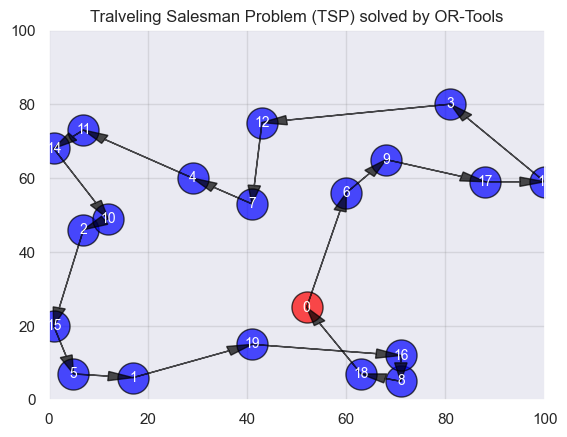

In [6]:
def plot_map():
    sns.set()
    plt.title('Tralveling Salesman Problem (TSP) solved by OR-Tools')
    plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)
    plt.xlim(0, MAX_X)
    plt.ylim(0, MAX_X) 

    # Draw nodes
    for index, node in enumerate(data['num_locations']):

        node_kwargs = dict(s=500, color='blue', alpha=0.7, edgecolors='black')

        if index == 0:
            node_kwargs['color'] = 'red'

        plt.scatter(x=node[0], y=node[1], **node_kwargs)
        plt.text(x=node[0], y=node[1], s=str(index), fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
    
    # Draw lines
    for route in routes: 
        arrow_kwargs = dict(length_includes_head=True, head_width=2.5, head_length=5, color='black', alpha=0.7)

        for index, node in enumerate(route):
            start_loc = data['num_locations'][route[index]]
            end_loc = data['num_locations'][route[index + 1]] if index < (len(route) - 1) else data['num_locations'][route[-1]]
            plt.arrow(x=start_loc[0], y=start_loc[1], dx=(end_loc[0] - start_loc[0]), dy=(end_loc[1] - start_loc[1]), **arrow_kwargs)
    
    return

plot_map()

由於 Routing Solver 並不總是向 TSP 返回最佳解，因為路徑問題在計算上很難處理。

為了找到更好的解決方案，您可以使用更高級的搜尋策略，稱為 Guided Local Search ，它使 Solver 能夠逃脫 Local Minimum - 比所有附近路線都短的解決方案，但不是 Global Minimum。遠離 Local Minimum 後，Solver 繼續搜尋答案。

更多搜尋方法: https://developers.google.com/optimization/routing/routing_options

In [ ]:
# guided local search
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.seconds = 30
search_parameters.log_search = True

"""
When using GUIDED_LOCAL_SEARCH or other metaheuristics, 
you need to set a time limit for the solver 
— otherwise the solver will not terminate. 
The preceding code sets a time limit of 30 seconds.
"""

由於 Routing Solver 是處理整數，因此，如果距離矩陣包含非整數項目，您就必須將距離四捨五入為整數。如果有些差異比較小，則四捨五入會影響解決方案。

如要避免四捨五入的問題，您可以 scale 距離矩陣：將矩陣的所有項目乘以 100。這會讓任何路徑的長度乘以 100 倍，但不會改變解決方案。這種做法的好處是，當您將矩陣項目四捨五入時，與距離相差的小數值 (最多為 0.5) 是很小的，因此對解決方案沒有太大的影響。

縮放距離矩陣時，您也必須變更 Solution Printer，將縮放後的路徑長度除以縮放比例係數，這樣才能顯示該路徑未縮放的距離。